In [1]:
import os
import cv2
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from mpl_toolkits.axes_grid1 import ImageGrid

import torch
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader, RandomSampler
from gradcam.utils.image import show_cam_on_image
from gradcam.multimae_cam import MultiMAECAM
from gradcam.utils.model_targets import MultiMAESemanticSegmentationTarget
from multimae.models.multimae import pretrain_multimae_base
from multimae.models.criterion import MaskedMSELoss, MaskedL1Loss, MaskedCrossEntropyLoss
from multimae.utils.plot_utils import plot_predictions
from multimae.utils.train_utils import normalize_depth
from multimae.utils.datasets import build_multimae_pretraining_dataset
from multimae.utils.plot_utils import get_semseg_metadata
from multimae.tools.load_multimae import load_model

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

### load checkpoints

In [2]:
model_name = "depth-semseg"
model, args = load_model(model_name)
print(model.output_adapters.keys())

Model loaded from:  /home/chunwei/Documents/drone_offboard/vision_backbones/MultiMAE/results/pretrain/03-12-23-04-05/checkpoint-299.pth
odict_keys(['rgb', 'depth', 'semseg'])


In [3]:
seed = 7
torch.manual_seed(seed) # change seed to resample new mask
np.random.seed(seed)
random.seed(seed)
cudnn.benchmark = True

In [4]:
# configure for detectron dataset (for prediection)
flightmare_path = Path(os.environ["FLIGHTMARE_PATH"])
multimae_path = flightmare_path.parent / "vision_backbones/MultiMAE"
eval_data_path = multimae_path / "datasets/test/val"
metadata = get_semseg_metadata(eval_data_path)

In [5]:
args.eval_data_path = str(eval_data_path)
dataset_val = build_multimae_pretraining_dataset(args, args.eval_data_path)
sampler_val = RandomSampler(dataset_val)
data_loader_val = DataLoader(
    dataset_val, sampler=sampler_val,
    batch_size=1,
    num_workers=args.num_workers,
    pin_memory=args.pin_mem,
    drop_last=True,
)

In [6]:
inputs = iter(data_loader_val).next()[0]

if model_name != "no-standard-depth" and "depth" in inputs:
    inputs["depth"] = normalize_depth(inputs["depth"])
inputs = {k: v.to("cuda") for k,v in inputs.items()}

In [7]:
print(inputs["depth"].min())
print(inputs["depth"].max())

tensor(-0.8606, device='cuda:0')
tensor(5.2839, device='cuda:0')


In [8]:
masks = {
    "rgb": torch.ones((1, 14, 14), dtype=torch.long),
    "depth": torch.zeros((1, 14, 14), dtype=torch.long),
    "semseg": torch.ones((1, 14, 14), dtype=torch.long)
}
masks = {k: torch.LongTensor(v).flatten()[None].to("cuda") for k, v in masks.items()}

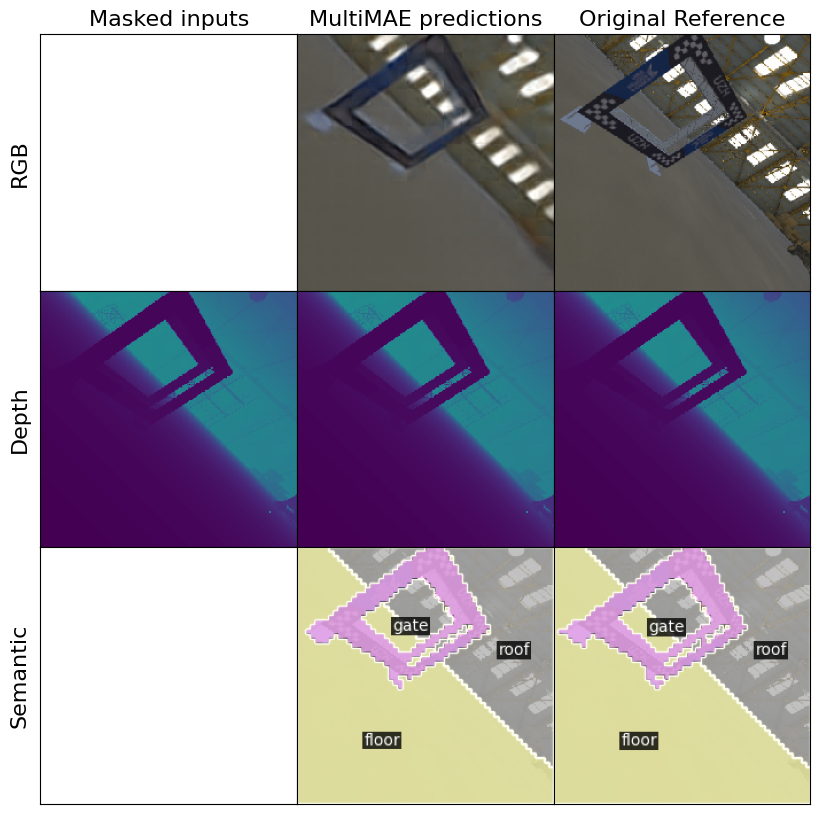

In [9]:
preds, masks = model(
    inputs, 
    num_encoded_tokens=196, 
    alphas=args.alphas, 
    sample_tasks_uniformly=args.sample_tasks_uniformly,
    mask_type=args.mask_type,
    masked_rgb_gate_only=True,
    semseg_gt=inputs["semseg"],
    in_domains=args.in_domains,
    semseg_stride=4,
    mask_inputs=True,
    task_masks=masks,
)

preds = {domain: pred.detach().cpu() for domain, pred in preds.items()}
masks = {domain: mask.detach().cpu() for domain, mask in masks.items()}

for domain in ["rgb", "depth", "semseg"]:
    if domain not in masks:
        masks[domain] = torch.ones_like(list(masks.values())[0])

res = plot_predictions(inputs, preds, masks, metadata=metadata)

In [10]:
print(preds["depth"].min())
print(preds["depth"].max())

tensor(-1.2771)
tensor(2.9823)


In [11]:
def plot_vis(res, image_float, grayscale_cam):
    fig = plt.figure(figsize=(10, 10))
    axs = ImageGrid(fig, 111, nrows_ncols=(2, 3), axes_pad=0)

    axs[0].imshow(res["rgb_input"])
    axs[0].axis('off')
    axs[0].set_title("RGB")

    axs[1].imshow(res["depth_input"] if res["depth_input"] is not None else res["rgb_input"])
    axs[1].axis('off')
    axs[1].set_title("Depth")

    axs[2].imshow(res["semseg_input"] if res["semseg_input"] is not None else res["rgb_input"])
    axs[2].axis('off')
    axs[2].set_title("Semseg")

    cam_rgb = show_cam_on_image(image_float, grayscale_cam[0, :, :], use_rgb=True)
    axs[3].imshow(cam_rgb)
    axs[3].axis('off')

    axs[4].imshow(cam_rgb)
    axs[4].axis('off')

    axs[5].imshow(cam_rgb)
    axs[5].axis('off')

In [12]:
target_layers = [model.encoder[-1].norm1]
cam = MultiMAECAM(model=model, target_layers=target_layers, use_cuda=True)

gate_class_id = 3
gate_mask_semseg_gt = torch.zeros_like(inputs["semseg"])
gate_mask_semseg_gt[inputs["semseg"] == gate_class_id] = 1

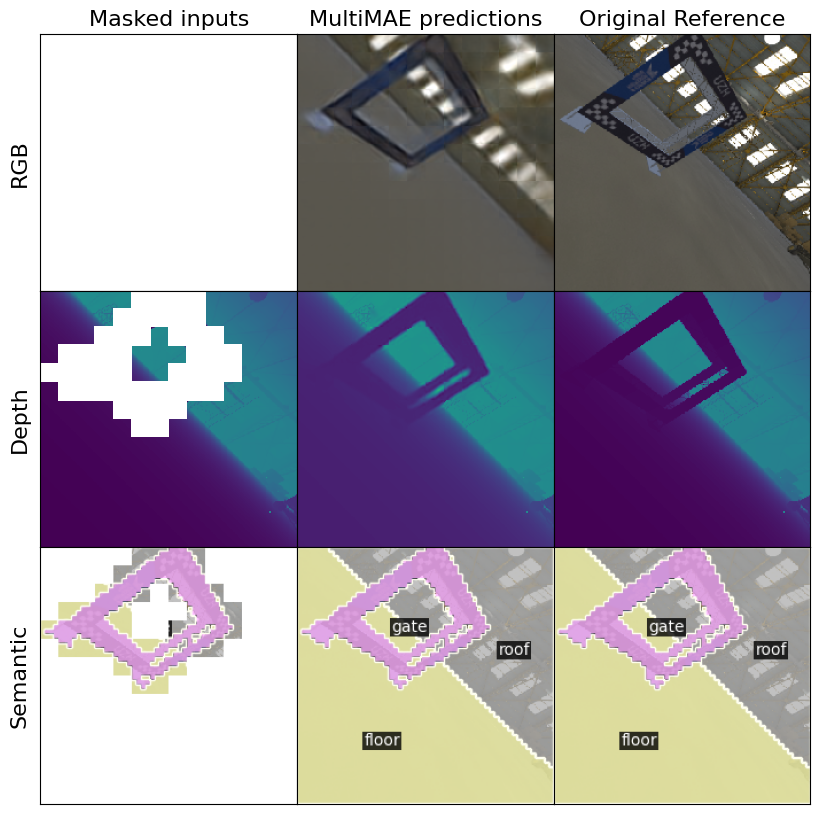

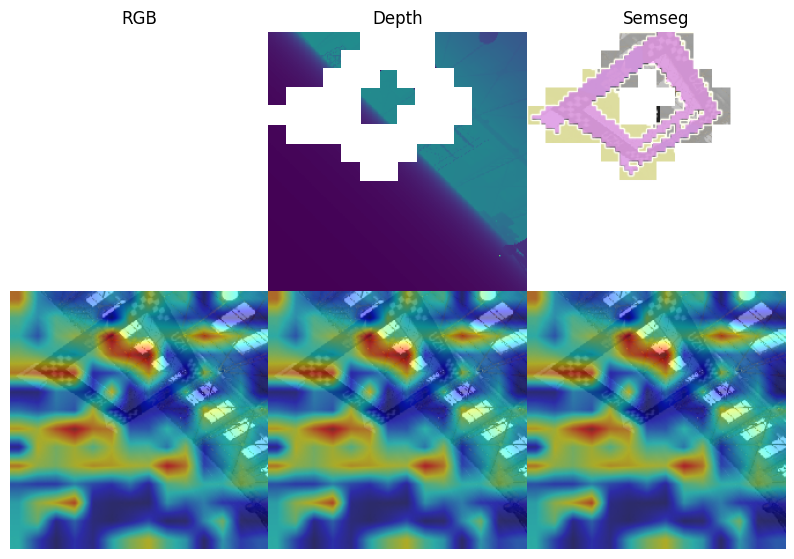

In [13]:
targets = {
    "rgb": MaskedMSELoss(),
    "depth": MaskedL1Loss(),
    "semseg": MultiMAESemanticSegmentationTarget(gate_class_id, gate_mask_semseg_gt)
}

targets = {domain: target for domain, target in targets.items() if domain in args.in_domains}

preds, task_masks, all_grayscale_cam = cam(
    input_tensor=inputs, 
    targets=targets, 
    num_encoded_tokens=196, 
    mask_type="gate-oriented", 
    semseg_gt=inputs["semseg"],
    masked_rgb_gate_only=True,
    in_domains=args.in_domains)

preds = {domain: pred.detach().cpu() for domain, pred in preds.items()}
masks = {domain: mask.detach().cpu() for domain, mask in task_masks.items()}

all_res = plot_predictions(inputs, preds, masks, show_img=True, metadata=metadata)
image_float = all_res["rgb_gt"].numpy().astype(np.float32)
plot_vis(all_res, image_float, all_grayscale_cam)

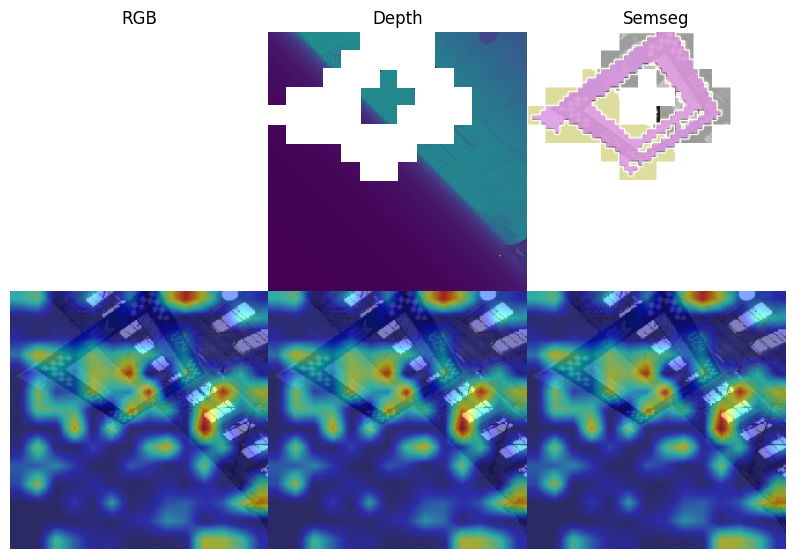

In [14]:
targets = {
    "rgb": MaskedMSELoss()
}
preds, task_masks, rgb_grayscale_cam = cam(
    input_tensor=inputs, 
    targets=targets, 
    # inputs for multimae preditions
    num_encoded_tokens=196, 
    mask_inputs=True,
    task_masks=task_masks)

preds = {domain: pred.detach().cpu() for domain, pred in preds.items()}
masks = {domain: mask.detach().cpu() for domain, mask in task_masks.items()}

rgb_res = plot_predictions(inputs, preds, masks, show_img=False, metadata=metadata)
plot_vis(rgb_res, image_float, rgb_grayscale_cam)

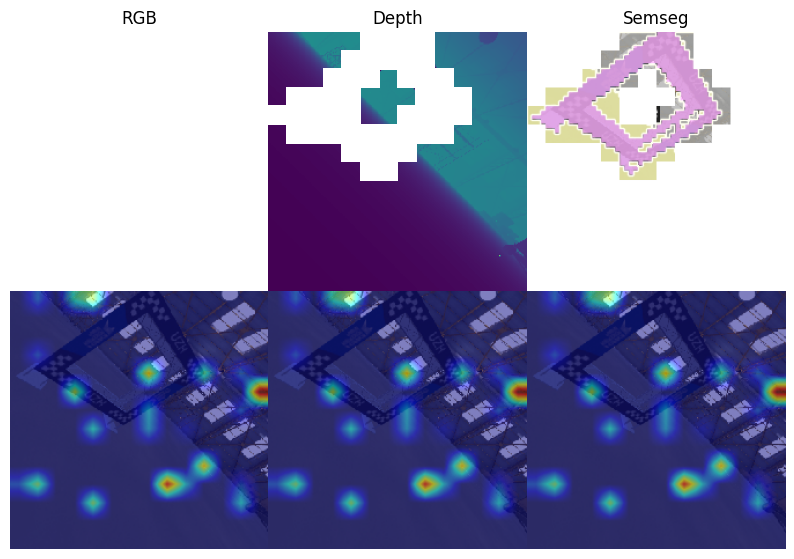

In [15]:
if "depth" in args.in_domains:
    targets = {
        "depth": MaskedL1Loss(),
    }
    preds, task_masks, depth_grayscale_cam = cam(
        input_tensor=inputs, 
        targets=targets, 
        # inputs for multimae preditions
        num_encoded_tokens=196, 
        mask_inputs=True,
        task_masks=task_masks)

    preds = {domain: pred.detach().cpu() for domain, pred in preds.items()}
    masks = {domain: mask.detach().cpu() for domain, mask in task_masks.items()}

    depth_res = plot_predictions(inputs, preds, masks, show_img=False, metadata=metadata)
    plot_vis(depth_res, image_float, depth_grayscale_cam)

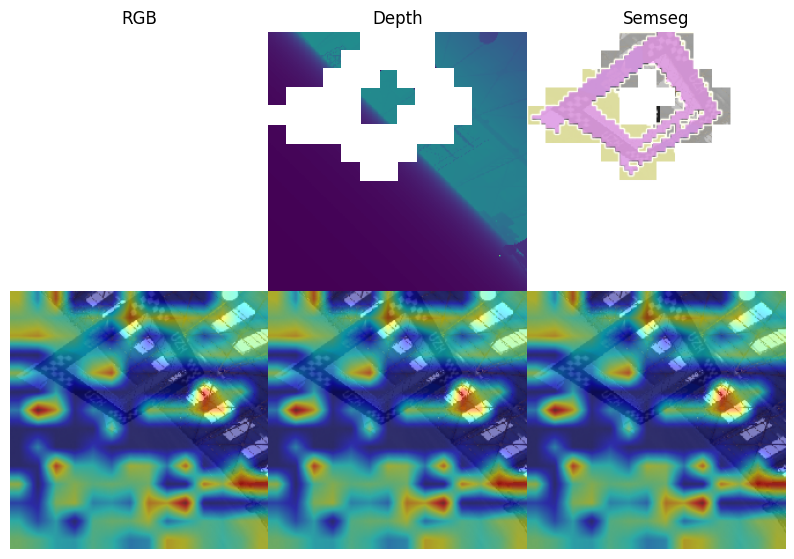

In [16]:
targets = {
    "semseg": MultiMAESemanticSegmentationTarget(gate_class_id, gate_mask_semseg_gt)
}
preds, task_masks, semseg_grayscale_cam = cam(
    input_tensor=inputs, 
    targets=targets, 
    # inputs for multimae preditions
    num_encoded_tokens=196, 
    mask_inputs=True,
    task_masks=task_masks)

preds = {domain: pred.detach().cpu() for domain, pred in preds.items()}
masks = {domain: mask.detach().cpu() for domain, mask in task_masks.items()}

semseg_res = plot_predictions(inputs, preds, masks, show_img=False, metadata=metadata)
plot_vis(semseg_res, image_float, semseg_grayscale_cam)

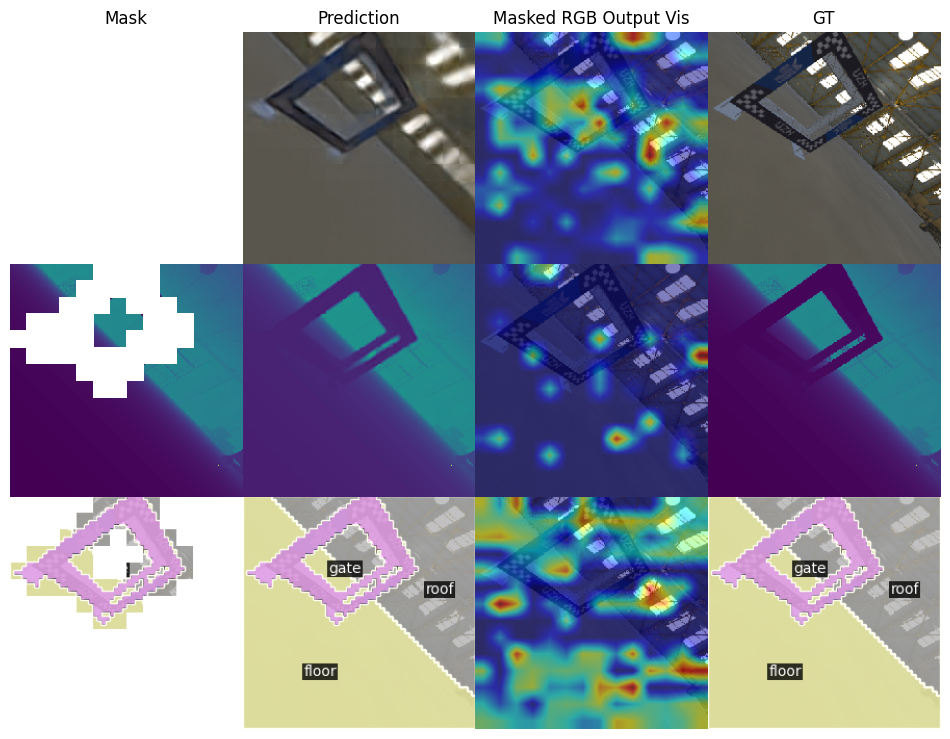

In [17]:
fig = plt.figure(figsize=(12, 12))
axs = ImageGrid(fig, 111, nrows_ncols=(3, 4), axes_pad=0)

axs[0].imshow(all_res["rgb_input"])
axs[0].axis('off')
axs[0].set_title("Mask")
axs[0].set_ylabel("RGB")

axs[1].imshow(all_res["rgb_pred"])
axs[1].axis('off')
axs[1].set_title("Prediction")

cam_rgb = show_cam_on_image(image_float, rgb_grayscale_cam[0, :, :], use_rgb=True)
axs[2].imshow(cam_rgb)
axs[2].axis('off')
axs[2].set_title("Masked RGB Output Vis")

axs[3].imshow(all_res["rgb_gt"])
axs[3].axis('off')
axs[3].set_title("GT")

if "depth" in args.in_domains:
    axs[4].imshow(all_res["depth_input"])
    axs[4].axis('off')
    axs[4].set_ylabel("Depth")

    axs[5].imshow(all_res["depth_pred"])
    axs[5].axis('off')

    cam_depth = show_cam_on_image(image_float, depth_grayscale_cam[0, :, :], use_rgb=True)
    axs[6].imshow(cam_depth)
    axs[6].axis('off')

    axs[7].imshow(all_res["depth_gt"])
    axs[7].axis('off')

axs[8].imshow(all_res["semseg_input"])
axs[8].axis('off')
axs[8].set_ylabel("Semseg")

axs[9].imshow(all_res["semseg_pred"])
axs[9].axis('off')

cam_semseg = show_cam_on_image(image_float, semseg_grayscale_cam[0, :, :], use_rgb=True)
axs[10].imshow(cam_semseg)
axs[10].axis('off')

axs[11].imshow(all_res["semseg_gt"])
axs[11].axis('off')

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])